 In order to first evaluate the bhdsgan I will use the following procedure:
 1. Sample from a truncated normal distribution with high variance --> gan should perform poorly
 2. Train gan on sampled data
 3. Generate new data and estimate density
 4. Compare actual and estimated density
 5. Sample from a truncated normal distribution with low variance --> gan should perform quite well
 6.Train gan on sampled data
 7. Generate new data and estimate density
 8. Compare actual and estimated density

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from bhsgan import DiscriminatorBhsSim, GeneratorBhsSim
from dataset import SampleDataset
from ipmbhsgan import DiscriminatorIpmSim, GeneratorIpmSim
from trainer import (Trainer, TrainingParams, get_dis_loss_bhs,
                     get_dis_loss_ipm, get_dis_loss_wasserstein,
                     get_gen_loss_bhs, get_gen_loss_ipm,
                     get_gen_loss_wasserstein)
from utils import get_device, get_noise
from wgan import DiscriminatorWassersteinSim, GeneratorWassersteinSim

torch.set_default_dtype(torch.float64)

## sample from truncated normal distributions

In [3]:
# sample from beta distributions
a_low = 2
b_low = 5
a_high = 2
b_high = 2


C:\Users\Rick\AppData\Local\Temp\ipykernel_11692\2406008146.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(beta_sample_high, bw=0.5)


<AxesSubplot:ylabel='Density'>

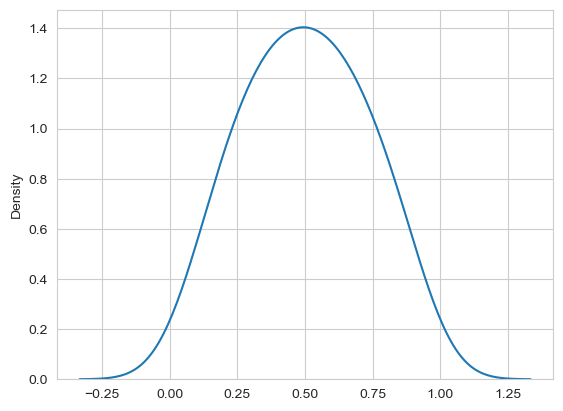

In [4]:
beta_sample_high = np.random.beta(a_high, b_high, 10000)
sns.set_style('whitegrid')
sns.kdeplot(beta_sample_high, bw=0.5)

C:\Users\Rick\AppData\Local\Temp\ipykernel_11692\3732047866.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(beta_sample_low, bw=0.5)


<AxesSubplot:ylabel='Density'>

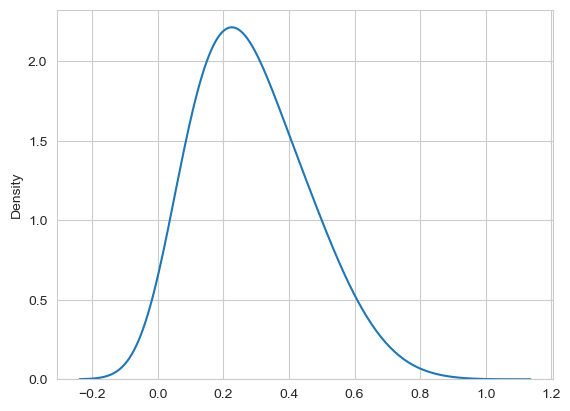

In [5]:
beta_sample_low = np.random.beta(a_low, b_low, 10000)
sns.set_style('whitegrid')
sns.kdeplot(beta_sample_low, bw=0.5)

In [6]:
training_set_high = SampleDataset(beta_sample_high)
training_set_low = SampleDataset(beta_sample_low)
#training_set_high = SampleDataset(np.random.normal(expected_value, standard_deviation_high, 10000))
#training_set_low = SampleDataset(np.random.normal(expected_value, standard_deviation_low, 10000))

In [7]:
np.mean(training_set_low)

0.28651842929984705

In [8]:
np.std(training_set_low)

0.16037393935113736

## Train GAN on both samples

In [9]:
training_params = TrainingParams(lr=0.0002, num_epochs=15, num_dis_updates=2, beta_1=0.5, batch_size=20)

# get device to train on
device = get_device()

In [10]:
# Create the dataloaders
dataloader_high = torch.utils.data.DataLoader(training_set_high, batch_size=training_params.batch_size,
                                         shuffle=True, num_workers=1)
dataloader_low = torch.utils.data.DataLoader(training_set_low, batch_size=training_params.batch_size,
                                         shuffle=True, num_workers=1)

In [11]:
# initialize nets
generator_high = GeneratorBhsSim()
discriminator_high = DiscriminatorBhsSim()
generator_low = GeneratorBhsSim()
discriminator_low = DiscriminatorBhsSim()

In [12]:
# init Trainer
trainer_high = Trainer(training_params, generator_high, discriminator_high)
trainer_low = Trainer(training_params, generator_low, discriminator_low)

### Train on high variance samples

In [13]:
# training loop
trained_bhs_high = trainer_high.train_gan(dataloader_high, get_dis_loss_bhs, get_gen_loss_bhs, False)

Epoch 0 training... 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x20 and 1x16)

In [ ]:
test_noise = get_noise(1000, 1)

In [14]:
generated_data = trained_bhs_high.generator(test_noise)
generated_sample = torch.reshape(generated_data, (1, 1000)).detach().numpy().ravel()

NameError: name 'trained_bhs_high' is not defined

C:\Users\fottneal\AppData\Local\Temp\ipykernel_20000\1836415556.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(torch.reshape(test_noise, (1, 1000)).detach().numpy().ravel(), bw=0.5)


<AxesSubplot:ylabel='Density'>

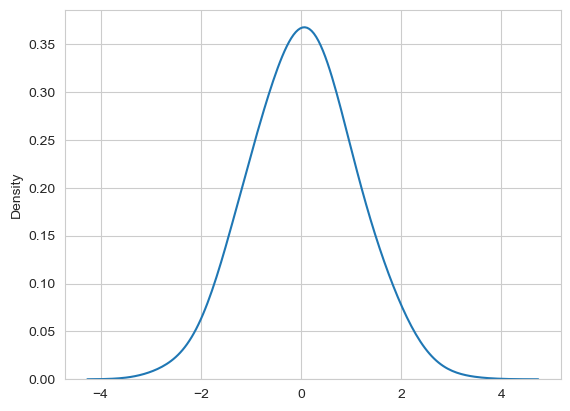

In [394]:
# plot test noise
sns.set_style('whitegrid')
sns.kdeplot(torch.reshape(test_noise, (1, 1000)).detach().numpy().ravel(), bw=0.5)

C:\Users\fottneal\AppData\Local\Temp\ipykernel_20000\1846206203.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(generated_sample, bw=0.5)


<AxesSubplot:ylabel='Density'>

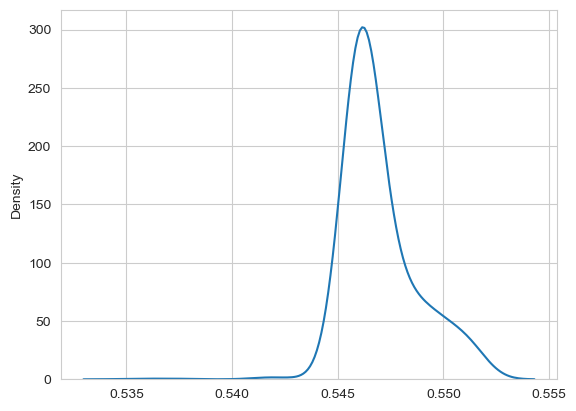

In [395]:
# plot resulting density
sns.set_style('whitegrid')
sns.kdeplot(generated_sample, bw=0.5)

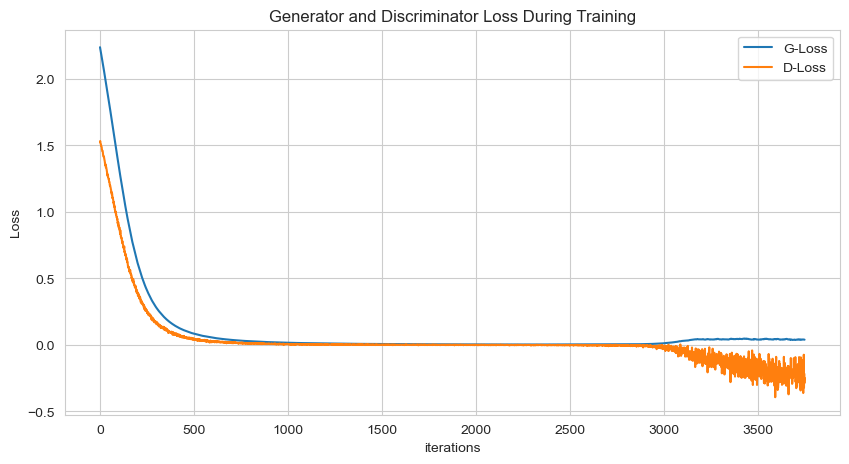

In [396]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trained_bhs_high.generator_losses,label="G-Loss")
plt.plot(trained_bhs_high.discriminator_losses,label="D-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [397]:
# check mean and varaince of generated data
np.mean(generated_sample)

0.546975854781489

In [398]:
np.std(generated_sample)

0.001688203949556228

### Train on low variance samples

In [399]:
# training loop
trained_bhs_low = trainer_low.train_gan(dataloader_low, get_dis_loss_bhs, get_gen_loss_bhs, False)

Epoch 0 training... done, took 5.3 seconds.
Epoch 1 training... done, took 6.0 seconds.
Epoch 2 training... done, took 5.3 seconds.
Epoch 3 training... done, took 5.1 seconds.
Epoch 4 training... done, took 5.6 seconds.
Epoch 5 training... done, took 5.3 seconds.
Epoch 6 training... done, took 5.4 seconds.
Epoch 7 training... done, took 5.5 seconds.
Epoch 8 training... done, took 5.7 seconds.
Epoch 9 training... done, took 5.8 seconds.
Epoch 10 training... done, took 5.8 seconds.
Epoch 11 training... done, took 6.9 seconds.
Epoch 12 training... done, took 5.9 seconds.
Epoch 13 training... done, took 5.5 seconds.
Epoch 14 training... done, took 5.7 seconds.


In [400]:
generated_data_low = trained_bhs_low.generator(test_noise)
generated_sample_low = torch.reshape(generated_data_low, (1, 1000)).detach().numpy().ravel()

C:\Users\fottneal\AppData\Local\Temp\ipykernel_20000\3230376598.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(generated_sample_low, bw=0.5)


<AxesSubplot:ylabel='Density'>

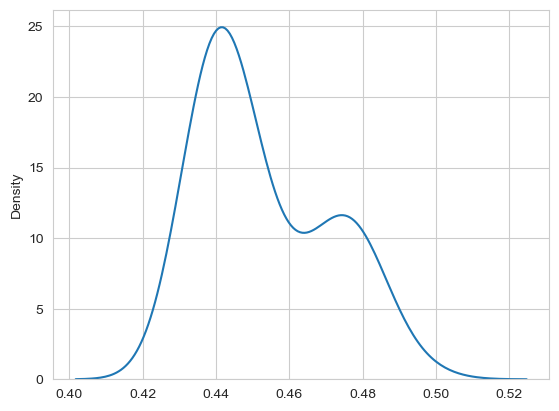

In [401]:
# plot resulting density
sns.set_style('whitegrid')
sns.kdeplot(generated_sample_low, bw=0.5)

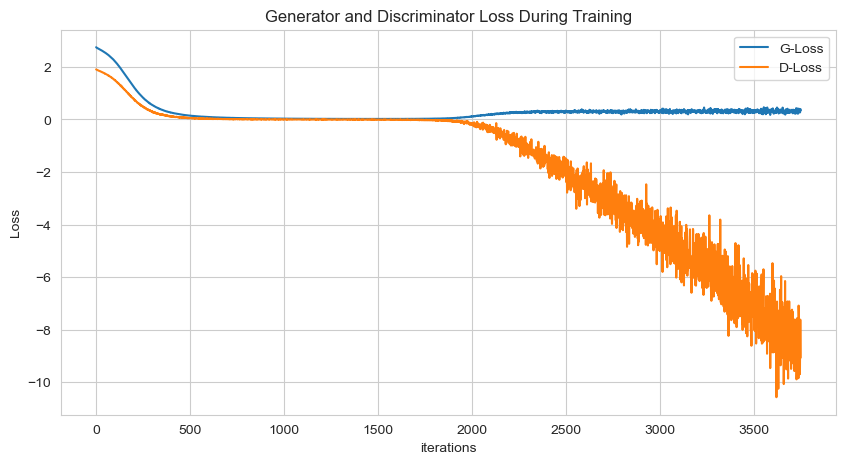

In [402]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trained_bhs_low.generator_losses,label="G-Loss")
plt.plot(trained_bhs_low.discriminator_losses,label="D-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [403]:
# check mean and varaince of generated data
np.mean(generated_sample)

0.546975854781489

In [404]:
np.std(generated_sample)

0.001688203949556228

## Now I train a Wasserstein GAN on the low variance second task as well

In [405]:
dataloader_wasserstein = torch.utils.data.DataLoader(training_set_low, batch_size=training_params.batch_size,
                                         shuffle=True, num_workers=1)
generator_wasserstein = GeneratorWassersteinSim()
discriminator_wasserstein = DiscriminatorWassersteinSim()
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein)

In [406]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader_wasserstein, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True)

Epoch 0 training... done, took 6.8 seconds.
Epoch 1 training... done, took 5.9 seconds.
Epoch 2 training... done, took 6.5 seconds.
Epoch 3 training... done, took 6.5 seconds.
Epoch 4 training... done, took 6.5 seconds.
Epoch 5 training... done, took 5.7 seconds.
Epoch 6 training... done, took 6.0 seconds.
Epoch 7 training... done, took 5.8 seconds.
Epoch 8 training... done, took 5.6 seconds.
Epoch 9 training... done, took 5.2 seconds.
Epoch 10 training... done, took 5.3 seconds.
Epoch 11 training... done, took 5.4 seconds.
Epoch 12 training... done, took 6.1 seconds.
Epoch 13 training... done, took 6.4 seconds.
Epoch 14 training... done, took 5.7 seconds.


In [407]:
generated_data_wasserstein = trained_wgan.generator(test_noise)
generated_sample_wasserstein = torch.reshape(generated_data_wasserstein, (1, 1000)).detach().numpy().ravel()

C:\Users\fottneal\AppData\Local\Temp\ipykernel_20000\2127257394.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(generated_sample_wasserstein, bw=0.5)


<AxesSubplot:ylabel='Density'>

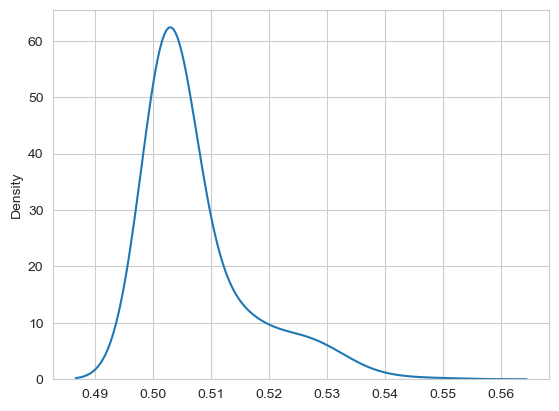

In [408]:
# plot resulting density
sns.set_style('whitegrid')
sns.kdeplot(generated_sample_wasserstein, bw=0.5)

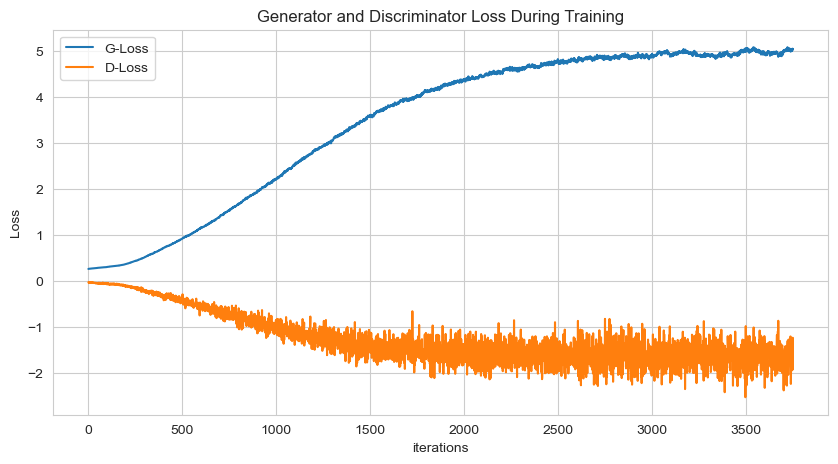

In [409]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trained_wgan.generator_losses,label="G-Loss")
plt.plot(trained_wgan.discriminator_losses,label="D-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [410]:
# check mean and varaince of generated data
np.mean(generated_sample_wasserstein)

0.5073661653190902

In [411]:
np.std(generated_sample_wasserstein)

0.008812519601702075

## Now I train the IPM Version for the BHS GAN

In [412]:
# initialize nets
generator_ipm = GeneratorIpmSim()
discriminator_ipm = DiscriminatorIpmSim()

In [413]:
dataloader_ipm = torch.utils.data.DataLoader(training_set_low, batch_size=training_params.batch_size,
                                         shuffle=True, num_workers=1)
# init Trainer
trainer_ipm_gan = Trainer(training_params, generator_ipm, discriminator_ipm)

In [414]:
# training loop
trained_ipm_gan = trainer_ipm_gan.train_gan(dataloader_ipm, get_dis_loss_ipm, get_gen_loss_ipm, False)

Epoch 0 training... done, took 5.8 seconds.
Epoch 1 training... done, took 6.4 seconds.
Epoch 2 training... done, took 5.6 seconds.
Epoch 3 training... done, took 6.3 seconds.
Epoch 4 training... done, took 5.2 seconds.
Epoch 5 training... done, took 5.6 seconds.
Epoch 6 training... done, took 4.7 seconds.
Epoch 7 training... done, took 4.7 seconds.
Epoch 8 training... done, took 4.5 seconds.
Epoch 9 training... done, took 4.6 seconds.
Epoch 10 training... done, took 4.8 seconds.
Epoch 11 training... done, took 5.1 seconds.
Epoch 12 training... done, took 4.9 seconds.
Epoch 13 training... done, took 4.9 seconds.
Epoch 14 training... done, took 5.1 seconds.


In [415]:
generated_data_ipm = trained_ipm_gan.generator(test_noise)
generated_sample_ipm = torch.reshape(generated_data_ipm, (1, 1000)).detach().numpy().ravel()

C:\Users\fottneal\AppData\Local\Temp\ipykernel_20000\3117575340.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(generated_sample_ipm, bw=0.5)


<AxesSubplot:ylabel='Density'>

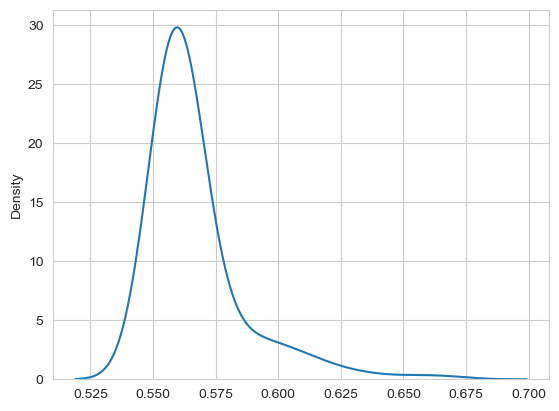

In [416]:
# plot resulting density
sns.set_style('whitegrid')
sns.kdeplot(generated_sample_ipm, bw=0.5)

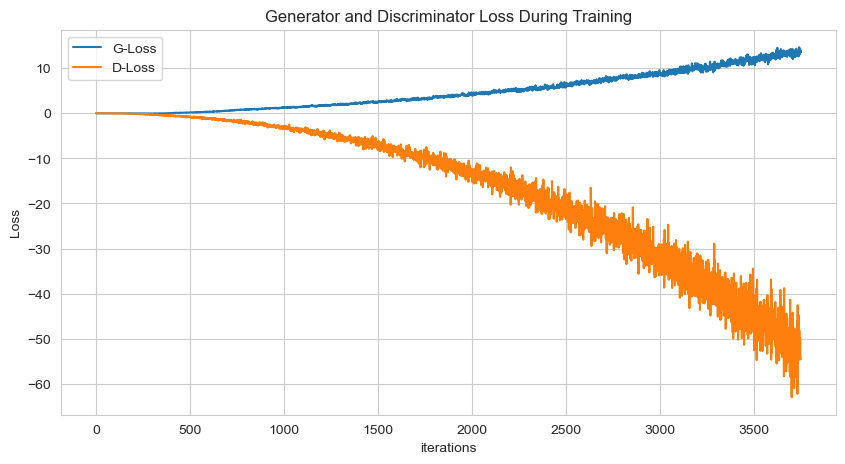

In [417]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trained_ipm_gan.generator_losses,label="G-Loss")
plt.plot(trained_ipm_gan.discriminator_losses,label="D-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [418]:
# check mean and varaince of generated data
np.mean(generated_sample_ipm)

0.566788790229668

In [419]:
np.std(generated_sample_ipm)

0.018895501347434226